In [1]:
import findspark

In [2]:
import pyspark

In [4]:
from pyspark.sql import SparkSession

In [6]:
spark = SparkSession.builder.appName("Tutorial").getOrCreate()

23/07/30 23:37:36 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [7]:
df = spark.read.csv('datacamp_ecommerce.csv',header=True,escape="\"")

In [8]:
df.show(5,0)

+---------+---------+--------------------+--------+------------+---------+----------+--------------+
|InvoiceNo|StockCode|         Description|Quantity| InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------------+--------+------------+---------+----------+--------------+
|   536365|   85123A|WHITE HANGING HEA...|       6|12/1/10 8:26|     2.55|     17850|United Kingdom|
|   536365|    71053| WHITE METAL LANTERN|       6|12/1/10 8:26|     3.39|     17850|United Kingdom|
|   536365|   84406B|CREAM CUPID HEART...|       8|12/1/10 8:26|     2.75|     17850|United Kingdom|
|   536365|   84029G|KNITTED UNION FLA...|       6|12/1/10 8:26|     3.39|     17850|United Kingdom|
|   536365|   84029E|RED WOOLLY HOTTIE...|       6|12/1/10 8:26|     3.39|     17850|United Kingdom|
+---------+---------+--------------------+--------+------------+---------+----------+--------------+
only showing top 5 rows



In [9]:
df.count()

2500

In [10]:
df.select('CustomerID').distinct().count()

95

In [11]:
from pyspark.sql.functions import *
from pyspark.sql.types import *

df.groupBy('Country').agg(countDistinct('CustomerID').alias('country_count')).show()

+--------------+-------------+
|       Country|country_count|
+--------------+-------------+
|       Germany|            2|
|        France|            1|
|          EIRE|            1|
|        Norway|            1|
|     Australia|            1|
|United Kingdom|           88|
|   Netherlands|            1|
+--------------+-------------+



In [12]:
df.groupBy('Country').agg(countDistinct('CustomerID').alias('country_count')).orderBy(desc('country_count')).show()

+--------------+-------------+
|       Country|country_count|
+--------------+-------------+
|United Kingdom|           88|
|       Germany|            2|
|        France|            1|
|          EIRE|            1|
|        Norway|            1|
|     Australia|            1|
|   Netherlands|            1|
+--------------+-------------+



In [13]:
df = df.withColumn('date',to_timestamp("InvoiceDate", 'yy/MM/dd HH:mm'))

In [14]:
spark.sql("set spark.sql.legacy.timeParserPolicy=LEGACY")

DataFrame[key: string, value: string]

In [15]:
df.select(max("date")).show()

+-------------------+
|          max(date)|
+-------------------+
|2012-01-10 17:06:00|
+-------------------+



In [16]:
df.select(min("date")).show()

+-------------------+
|          min(date)|
+-------------------+
|2012-01-10 08:26:00|
+-------------------+



In [17]:
df = df.withColumn("from_date", lit("12/1/10 08:26"))
df = df.withColumn('from_date',to_timestamp("from_date", 'yy/MM/dd HH:mm'))

df2=df.withColumn('from_date',to_timestamp(col('from_date'))).withColumn('recency',col("date").cast("long") - col('from_date').cast("long"))

In [18]:
df2 = df2.join(df2.groupBy('CustomerID').agg(max('recency').alias('recency')),on='recency',how='leftsemi')

In [19]:
df2.show(,0)

+-------+---------+---------+--------------------+--------+------------+---------+----------+--------------+-------------------+-------------------+
|recency|InvoiceNo|StockCode|         Description|Quantity| InvoiceDate|UnitPrice|CustomerID|       Country|               date|          from_date|
+-------+---------+---------+--------------------+--------+------------+---------+----------+--------------+-------------------+-------------------+
|    540|   536369|    21756|BATH BUILDING BLO...|       3|12/1/10 8:35|     5.95|     13047|United Kingdom|2012-01-10 08:35:00|2012-01-10 08:26:00|
|   1140|   536370|    22728|ALARM CLOCK BAKEL...|      24|12/1/10 8:45|     3.75|     12583|        France|2012-01-10 08:45:00|2012-01-10 08:26:00|
|   1140|   536370|    22727|ALARM CLOCK BAKEL...|      24|12/1/10 8:45|     3.75|     12583|        France|2012-01-10 08:45:00|2012-01-10 08:26:00|
|   1140|   536370|    22726|ALARM CLOCK BAKEL...|      12|12/1/10 8:45|     3.75|     12583|        Franc

In [20]:
df2.printSchema()

root
 |-- recency: long (nullable = true)
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: string (nullable = true)
 |-- InvoiceDate: string (nullable = true)
 |-- UnitPrice: string (nullable = true)
 |-- CustomerID: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- from_date: timestamp (nullable = true)



In [21]:
df_freq = df2.groupBy('CustomerID').agg(count('InvoiceDate').alias('frequency'))

In [22]:
df_freq.show(5,0)

+----------+---------+
|CustomerID|frequency|
+----------+---------+
|     16250|       14|
|     15100|        1|
|     13065|       14|
|     12838|       59|
|     15350|        5|
+----------+---------+
only showing top 5 rows



In [23]:
df3 = df2.join(df_freq,on='CustomerID',how='inner')

In [24]:
df3.printSchema()

root
 |-- CustomerID: string (nullable = true)
 |-- recency: long (nullable = true)
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: string (nullable = true)
 |-- InvoiceDate: string (nullable = true)
 |-- UnitPrice: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- from_date: timestamp (nullable = true)
 |-- frequency: long (nullable = false)



In [25]:
m_val = df3.withColumn('TotalAmount',col("Quantity") * col("UnitPrice"))

In [26]:
m_val = m_val.groupBy('CustomerID').agg(sum('TotalAmount').alias('monetary_value'))

In [27]:
finaldf = m_val.join(df3,on='CustomerID',how='inner')

In [29]:
finaldf = finaldf.select(['recency','frequency','monetary_value','CustomerID']).distinct()

In [30]:
finaldf.show(5,0)

+-------+---------+------------------+----------+
|recency|frequency|    monetary_value|CustomerID|
+-------+---------+------------------+----------+
|   5580|       14|            226.14|     16250|
|   2580|        1|             350.4|     15100|
|  30360|       14|205.85999999999999|     13065|
|  12660|       59|390.78999999999985|     12838|
|  18420|        5|            115.65|     15350|
+-------+---------+------------------+----------+
only showing top 5 rows



In [31]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler

assemble=VectorAssembler(inputCols=[
    'recency','frequency','monetary_value'
], outputCol='features')

assembled_data=assemble.transform(finaldf)

scale=StandardScaler(inputCol='features',outputCol='standardized')
data_scale=scale.fit(assembled_data)
data_scale_output=data_scale.transform(assembled_data)

In [32]:
data_scale_output.select('standardized').show(2,truncate=False)

+-------------------------------------------------------------+
|standardized                                                 |
+-------------------------------------------------------------+
|[0.6860448646904731,0.6848507976304103,0.45968090513788246]  |
|[0.31720353958806824,0.048917914116457885,0.7122675738936677]|
+-------------------------------------------------------------+
only showing top 2 rows



In [33]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import numpy as np

cost = np.zeros(10)

evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='standardized',metricName='silhouette', distanceMeasure='squaredEuclidean')

for i in range(2,10):
    KMeans_algo=KMeans(featuresCol='standardized', k=i)
    KMeans_fit=KMeans_algo.fit(data_scale_output)
    output=KMeans_fit.transform(data_scale_output)
    cost[i] = KMeans_fit.summary.trainingCost

23/07/30 23:46:41 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


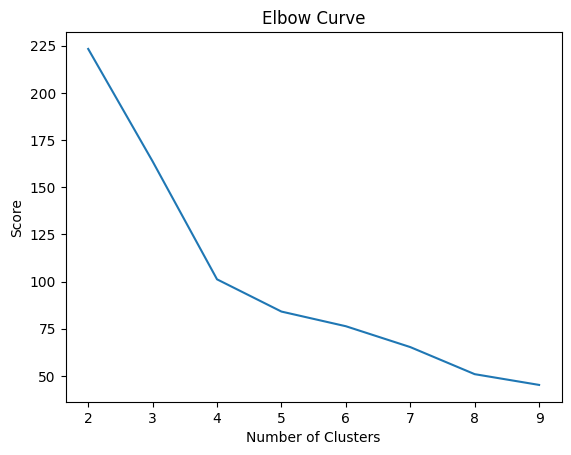

In [34]:
import pandas as pd
import pylab as pl
df_cost = pd.DataFrame(cost[2:])
df_cost.columns = ["cost"]
new_col = range(2,10)
df_cost.insert(0, 'cluster', new_col)
pl.plot(df_cost.cluster, df_cost.cost)
pl.xlabel('Number of Clusters')
pl.ylabel('Score')
pl.title('Elbow Curve')
pl.show()

In [35]:
KMeans_algo=KMeans(featuresCol='standardized', k=4)
KMeans_fit=KMeans_algo.fit(data_scale_output)

In [36]:
preds=KMeans_fit.transform(data_scale_output)

preds.show(5,0)

+-------+---------+------------------+----------+--------------------+--------------------+----------+
|recency|frequency|    monetary_value|CustomerID|            features|        standardized|prediction|
+-------+---------+------------------+----------+--------------------+--------------------+----------+
|   5580|       14|            226.14|     16250|[5580.0,14.0,226.14]|[0.68604486469047...|         2|
|   2580|        1|             350.4|     15100|  [2580.0,1.0,350.4]|[0.31720353958806...|         2|
|  30360|       14|205.85999999999999|     13065|[30360.0,14.0,205...|[3.73267421003633...|         1|
|  12660|       59|390.78999999999985|     12838|[12660.0,59.0,390...|[1.55651039193214...|         0|
|  18420|        5|            115.65|     15350|[18420.0,5.0,115.65]|[2.26468573612876...|         1|
+-------+---------+------------------+----------+--------------------+--------------------+----------+
only showing top 5 rows



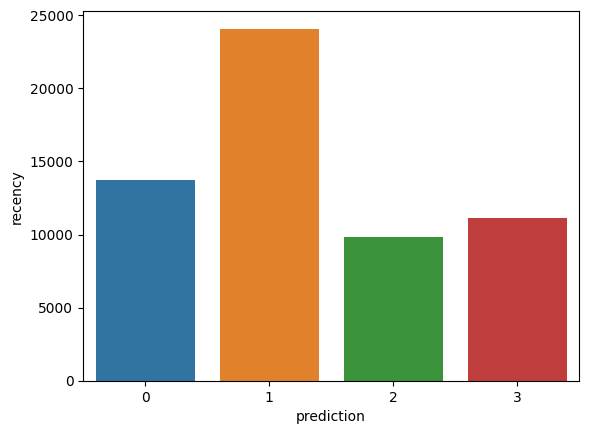

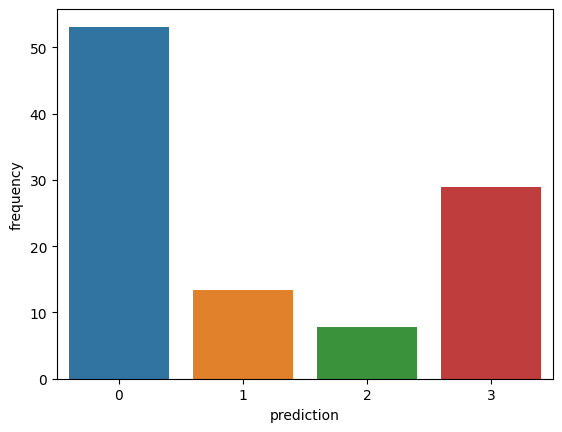

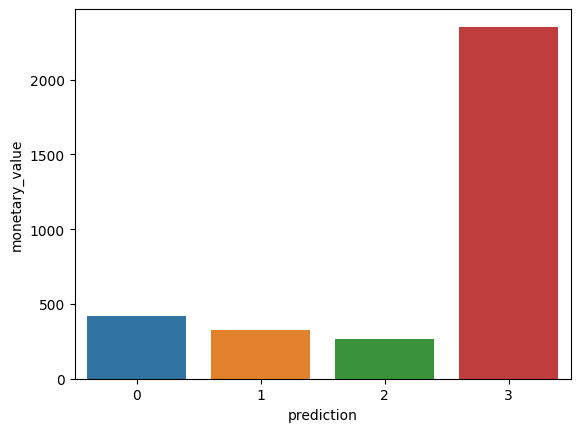

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

df_viz = preds.select('recency','frequency','monetary_value','prediction')
df_viz = df_viz.toPandas()
avg_df = df_viz.groupby(['prediction'], as_index=False).mean()

list1 = ['recency','frequency','monetary_value']

for i in list1:
    sns.barplot(x='prediction',y=str(i),data=avg_df)
    plt.show()

In [38]:
spark.stop()